In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import itertools
import tensorflow as tf
from keras.utils import to_categorical
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Using Theano backend.


In [3]:
def Split_Train_Dev_Test(Num_batches , seed):

    np.random.seed(seed)

    p = np.random.permutation( Num_batches )
    p = p + 1
    p = p.tolist()
    
    # 80 10 10 split
    num_dev =  Num_batches//10
    num_test = Num_batches//10
    
    batch_train = p[0:-(num_dev+num_test)]
    batch_dev = p[-(num_dev+num_test):-num_test]
    batch_test = p[-num_test:]


    return batch_train, batch_dev, batch_test

In [4]:
def ImportValues(folder,batch):
   # This function loads the x and y values, reshapes X to volume and tranform Y to 1-hot 

    name_img = folder + 'X_Img_Values' + str(batch) + '.npy'
    name_sex = folder + 'X_Sex_Values' + str(batch) + '.npy'
    name_age = folder + 'X_Age_Values' + str(batch) + '.npy'
    namey = folder + 'YValues' + str(batch) + '.npy'
    
    X_img=np.load(name_img)
    X_sex=np.load(name_sex)
    X_age=np.load(name_age)
    Y=np.load(namey)
    Y=np.squeeze(Y)

    # length check
    assert(len(X_img) == len(Y))


    n_classes = 2 # 3 labels: 0:normal, 1:MCI, 2:Alzh

    X_img = np.reshape(X_img,(-1,116,130,83,1)) ######################

    
    # change lables to 1-hot form matrix
    Y = to_categorical(Y, n_classes)

    return X_img, X_age, X_sex ,Y


In [5]:
def my_Scores(y_pred, y_true):
    
    macro    = np.empty([3])
    micro    = np.empty([3])
    weighted = np.empty([3])

    macro[0] = precision_score(y_true, y_pred, average='macro')
    macro[1] = recall_score(y_true, y_pred, average='macro')
    macro[2] = f1_score(y_true, y_pred, average='macro')  

    micro[0] = precision_score(y_true, y_pred, average='micro')  
    micro[1] = recall_score(y_true, y_pred, average='micro') 
    micro[2] = f1_score(y_true, y_pred, average='micro')  

    weighted[0] = precision_score(y_true, y_pred, average='weighted')
    weighted[1] = recall_score(y_true, y_pred, average='weighted') 
    weighted[2] = f1_score(y_true, y_pred, average='weighted') 

    return (macro, micro, weighted)


In [6]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
      
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar().ax.tick_params(labelsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontdict=font)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 20)
    plt.xlabel('Predicted Label', fontsize = 20)


In [8]:
#load the model to Evaluate the test and validation Set


#directory of the dataset
folder='../../.././Data_Set/XY_Values_BatchSize8_Scaled_TwoGroups (1)/'

#directory of the saved model
save_name = '.././best/Report/CNN_trained_best'

#dimensions of our input and output
n_x = 189
n_y = 212
n_z = 135
n_classes = 3
Num_batches = 104
seed = 0
 
#Spliting of the dataset as in experiment
batch_train, batch_dev, batch_test = Split_Train_Dev_Test(Num_batches , seed)




with tf.Session() as sess:

    new_saver = tf.train.import_meta_graph(save_name + '.meta')
    new_saver.restore(sess, save_name)

    #load the model to Evaluate the test and validation Set
    x_img_input = sess.graph.get_tensor_by_name('Input_img:0' )  
    x_age_input = sess.graph.get_tensor_by_name('Input_age:0' )
    x_sex_input = sess.graph.get_tensor_by_name('Input_sex:0' )
    y_input = sess.graph.get_tensor_by_name('Output:0') 
    cost = sess.graph.get_tensor_by_name('Cost:0' )
    
    prediction = sess.graph.get_tensor_by_name('Prediction/BiasAdd:0')
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
    accuracy = sess.graph.get_tensor_by_name('accuracy:0')       

    import datetime

    start_time = datetime.datetime.now()

    num_of_dev_batches = len(batch_dev)
    num_of_test_batches = len(batch_test)
    
    epoch_dev_acc = 0
    epoch_test_acc = 0
    
    start_time_epoch = datetime.datetime.now()

    Y_pred = np.zeros((0,0))
    Y_true = np.zeros((0,0))
    
       
    for itr in range(num_of_dev_batches):

        mini_batch_x_img , mini_batch_x_age , mini_batch_x_sex , mini_batch_y = ImportValues(folder, batch_dev[itr])
        
        
#         print(mini_batch_x_img.shape , mini_batch_x_age.shape , mini_batch_x_sex.shape , mini_batch_y.shape)
        param2 , y_pred , y_true = sess.run([accuracy, tf.argmax(prediction, 1), tf.argmax(y_input, 1)], feed_dict={ x_img_input: mini_batch_x_img,
                                    x_age_input: mini_batch_x_age, x_sex_input: mini_batch_x_sex, y_input: mini_batch_y})
        epoch_dev_acc += param2
        Y_pred = np.append(Y_pred,y_pred)
        Y_true = np.append(Y_true,y_true)
    
    end_time_epoch = datetime.datetime.now()
    print(Y_pred,Y_true)
    Conf_mat = confusion_matrix(y_pred=Y_pred,y_true=Y_true)
    print(Conf_mat)

    dev_acc        = epoch_dev_acc/num_of_dev_batches
    elapsed_time   = end_time_epoch - start_time_epoch
    print(itr,dev_acc)
    
    Y_pred_test = np.zeros((0,0))
    Y_true_test = np.zeros((0,0))
    
    start_time_epoch = datetime.datetime.now()
    for itr in range(num_of_test_batches):

        mini_batch_x_img , mini_batch_x_age , mini_batch_x_sex , mini_batch_y = ImportValues(folder, batch_test[itr])
        
        
#         print(mini_batch_x_img.shape , mini_batch_x_age.shape , mini_batch_x_sex.shape , mini_batch_y.shape)
        param2 , y_pred , y_true = sess.run([accuracy, tf.argmax(prediction, 1), tf.argmax(y_input, 1)], feed_dict={ x_img_input: mini_batch_x_img,
                                    x_age_input: mini_batch_x_age, x_sex_input: mini_batch_x_sex, y_input: mini_batch_y})
        epoch_test_acc += param2
        Y_pred_test = np.append(Y_pred,y_pred)
        Y_true_test = np.append(Y_true,y_true)
    
    end_time_epoch = datetime.datetime.now()
    print(Y_pred_test,Y_true_test)
    Conf_mat_test = confusion_matrix(y_pred=Y_pred_test,y_true=Y_true_test)
    print(Conf_mat_test)

    dev_acc        = epoch_test_acc/num_of_test_batches
    elapsed_time   = end_time_epoch - start_time_epoch   
    print(itr,dev_acc)
    
    
    
    
                                           
    end_time = datetime.datetime.now()
    print('Time elapse: ', str(end_time - start_time))


[38, 82, 47, 40, 66, 59, 13, 93, 89, 71]
INFO:tensorflow:Restoring parameters from .././best/Report/CNN_trained_best
[ 1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.] [ 1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.
  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.
  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.  1.  0.]
[[44  4]
 [ 6 26]]
9 0.875
[ 1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  

Normalized confusion matrix
[[ 0.91666667  0.08333333]
 [ 0.1875      0.8125    ]]


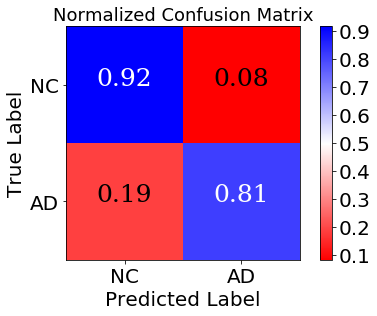

In [10]:
#Plot Confussion matrix for Validation Set

class_names = ['NC','AD']
cmap = mpl.cm.bwr
cmap_r = reverse_colourmap(cmap)


plt.figure()
plot_confusion_matrix(Conf_mat, cmap=cmap_r, classes=class_names, normalize=True)
# plt.colorbar()
# cb = plt.colorbar()
# plt.colorbar().remove()
plt.draw()
# plt.colorbar().ax.tick_params(labelsize=25)
# plt.xticks((-1, 0, 1), ('-1', '0', '1'), color='k', size=20)
plt.tick_params(labelsize = 20)
plt.title('Normalized Confusion Matrix', fontsize = 18)
plt.draw()
plt.savefig('Conf_Mat_dev.pdf',bbox_inches = 'tight', pad_inches=0.1)

plt.show()

Normalized confusion matrix
[[ 0.92307692  0.07692308]
 [ 0.16666667  0.83333333]]


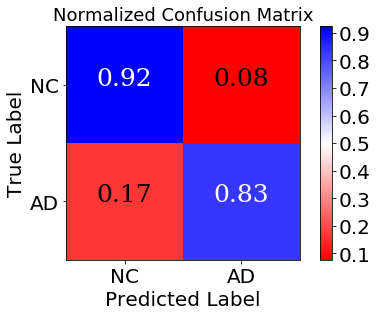

In [11]:
#Plot Confussion matrix for Test Set

class_names = ['NC','AD']

cmap = mpl.cm.bwr
cmap_r = reverse_colourmap(cmap)


plt.figure()
plot_confusion_matrix(Conf_mat_test, cmap=cmap_r , classes=class_names, normalize=True)
# plt.colorbar()
# cb = plt.colorbar()
# plt.colorbar().remove()
plt.draw()
# plt.colorbar().ax.tick_params(labelsize=25)
# plt.xticks((-1, 0, 1), ('-1', '0', '1'), color='k', size=20)
plt.tick_params(labelsize = 20)
plt.title('Normalized Confusion Matrix', fontsize = 18)
plt.draw()
plt.savefig('Conf_Mat_test.pdf',bbox_inches = 'tight', pad_inches=0.1)

plt.show()